In [59]:
import os
from os.path import expanduser
import socket
import sys
import glob

# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
#########################################

In [60]:
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

import xarray as xr
import pandas as pd

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

In [61]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/home/hbkoziel/pyfesom/data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'SAPE'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [62]:
dates = pd.date_range('1985', freq="Y", periods= len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*_v2.nc', concat_dim='time')
data['time'] = dates
#data.time.data = dates

In [63]:
data
#data.where(data.apply(np.isfinite)).fillna(0.0)

<xarray.Dataset>
Dimensions:  (nod2d: 753179, time: 31)
Coordinates:
  * time     (time) datetime64[ns] 1985-12-31 1986-12-31 ... 2015-12-31
Dimensions without coordinates: nod2d
Data variables:
    HLD      (time, nod2d) float64 dask.array<shape=(31, 753179), chunksize=(1, 753179)>
    HLT      (time, nod2d) float64 dask.array<shape=(31, 753179), chunksize=(1, 753179)>
    APE      (time, nod2d) float64 dask.array<shape=(31, 753179), chunksize=(1, 753179)>
Attributes:
    description:  Mean Summer (Sept) Halocline indicators
    history:      Created Wed Dec 30 21:43:23 2020

In [64]:
ind_fram = (np.array(np.abs(mesh.x2)<20) & np.array(mesh.y2<80))

In [65]:
ANPP_sel = data.APE.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))

ANPP_sel = ANPP_sel.compute()
ANPP_sel = ANPP_sel.fillna(0)
ANPP_mean = ANPP_sel.mean(dim='time')
ANPP_mean = ANPP_mean.compute()
ANPP_min = ANPP_sel.min(dim='time')
ANPP_min = ANPP_min.compute()

In [66]:
ANPP_sel.shape
#plt.plot(ANPP_sel[30,:])

(31, 753179)

In [67]:
pf = np.polyfit(years, ANPP_sel, 1)

In [68]:
ANPP_trend = pf[0]
#plt.plot(ANPP_trend)

In [69]:
import pyfesom as pf

ANPP_trend[ANPP_trend == 0] = np.nan
ANPP_trend[ind_fram]=np.nan

data, elem_no_nan = pf.get_data(ANPP_trend,mesh,0)

data2=np.copy(data)
data2 = data2 /10**5
print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
print 'Mean of surface: ',np.mean(data2)
print 'Max and min: ',np.max(data2),np.min(data2)

For depth 0 model level -0.0 will be used
Number of nans in tracer:  560663
Number of inf in tracer:  0
Mean of surface:  nan
Max and min:  nan nan


In [70]:
# ind = 650000
# print mesh.x2[ind]
# print mesh.y2[ind]
# print ANPP_trend[ind]
# pf = np.polyfit(years, ANPP_sel[:,ind],1)
# print pf[0]
# plt.plot(years,ANPP_sel[:,ind])
# plt.plot(years, years*pf[0]+pf[1])

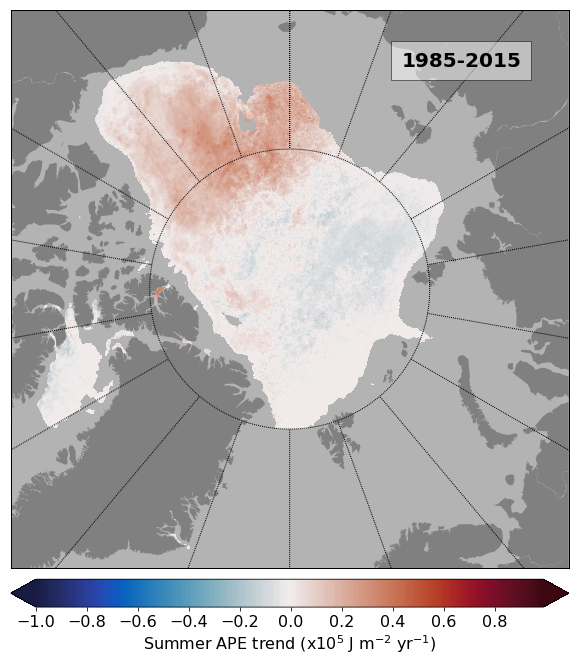

In [71]:
contours = np.arange(-1, 1, .01)

fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.suptitle('Density (kg m$^{-3}$)')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)

m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')

#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps

im=plt.tricontourf(x, y, elem_no_nan, data2, levels=contours, cmap=cmap.cm.balance, extend='both')

plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

label = 'Summer APE trend (x10${^5}$ J m$^{-2}$ yr$^{-1}$)'
#plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.savefig(wd_path+'figures/'+runid+'/trend/APESv2.png', dpi = 200, bbox_inches='tight')
plt.show()

In [72]:
ANPP_mean[ANPP_mean == 0] = np.nan
ANPP_mean[ind_fram] = np.nan

data, elem_no_nan = pf.get_data(ANPP_mean,mesh,0)

data2=np.copy(data)
data2 = data2 /10**5

print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
print 'Mean of surface: ',np.mean(data2)
print 'Max and min: ',np.max(data2),np.min(data2)

For depth 0 model level -0.0 will be used
Number of nans in tracer:  560663
Number of inf in tracer:  0
Mean of surface:  nan
Max and min:  nan nan


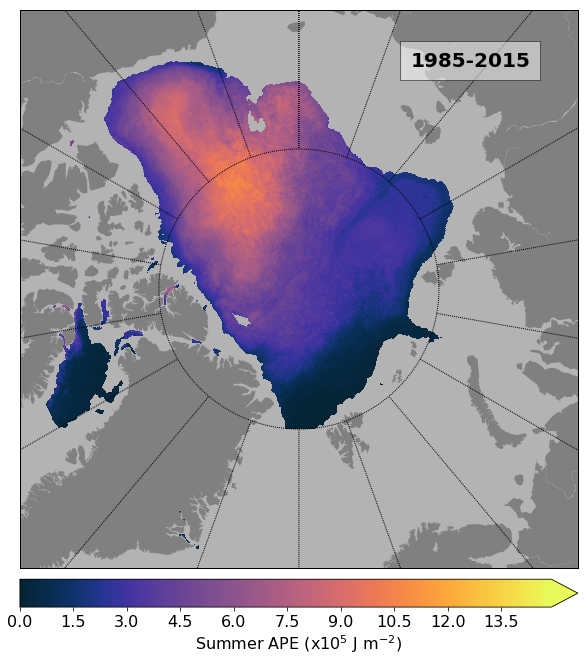

In [73]:
contours = np.arange(0, 15, 0.1)

fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.suptitle('Density (kg m$^{-3}$)')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)

m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')

#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps

im=plt.tricontourf(x, y, elem_no_nan, data2, levels=contours, cmap=cmap.cm.thermal, extend='max')

plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

label = 'Summer APE (x10${^5}$ J m$^{-2}$)'
#plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16) 

plt.savefig(wd_path+'figures/'+runid+'/meanstate/APESv2.png', dpi = 200, bbox_inches='tight')

plt.show()